### init

In [8]:
%load_ext autoreload
import matplotlib
%reload_ext autoreload
%autoreload 2

%matplotlib notebook
#%matplotlib widget

import warnings
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import logging
import signal, threading, os, time
import logging

from IPython.core.debugger import set_trace
from IPython.terminal.embed import embed

import os, sys
import asyncio

import nest_asyncio
nest_asyncio.apply()

import inspect
#import ccxt.async_support as ccxt
import ccxt
import pandas as pd



In [29]:
import mplfinance as mpf
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 12]


In [13]:

try:
    from settings import HTTP_PROXY
except ImportError:
    HTTP_PROXY = None
    
# (!!!)You should change this according to your network environment
if HTTP_PROXY is None:
    HTTP_PROXY = 'http://127.0.0.1:1087'    

def kline_to_df(arr) -> pd.DataFrame:
    kline = pd.DataFrame(
        arr,
        columns=['ts', 'open', 'high', 'low', 'close', 'volume' ])
    kline.index = pd.to_datetime(kline.ts, unit='ms')
    kline.drop('ts', axis=1, inplace=True)
    return kline
    

In [14]:

PROXIES = {
    'http': HTTP_PROXY,
    'https': HTTP_PROXY,
}

ccxt_options = {'proxies': PROXIES}

ok = 'okex'
bn = 'binance'
hb = 'huobipro'

client_list = [hb, bn, ok]

### 参数设置  Parameters

In [23]:
from HarmonicPatterns.harmonic_functions import HarmonicDetector
from HarmonicPatterns.harmonic import send_alert, search_function
from functools import partial
import time
from multiprocessing import Pool

################
# HarmonicDetector params
# err_allowed: The error rate that detector would allow, usually 0.05 < err_rate < 0.1
# strict: for example 0.618 * (1 - err_rate) < pattern < 0.618 * (1 + err_rate), the base should be a fibbonacci number, like 0.382, 0.618, 0.786, 1.618....
# predict_err_rate: # similiar to err_allowed but used in predict


################
# search params
# only_last: find patterns in history or not
# symbols: symbols list to find
# periods: periods that used in ccxt
# last_n: if only_last is set, how near should the bar be
# alert: send alerts when patterns found
# plot: plot patterns when patterns found

detector = HarmonicDetector(error_allowed=0.07, strict=True, predict_err_rate=0.07)
search = partial(search_function, detector, ccxt_args=ccxt_options, only_last=False)
PERIODS = ['1h', '4h', '1d']
#PERIODS = ['5m','15m', '30m']


###  DETECT BTC

In [25]:
s = ['BTC/USDT', 'ETH/USDT']
search('binance', s, periods = ['15m', '30m', '1h', '4h'])

###  主流币 USDT

<IPython.core.display.Javascript object>


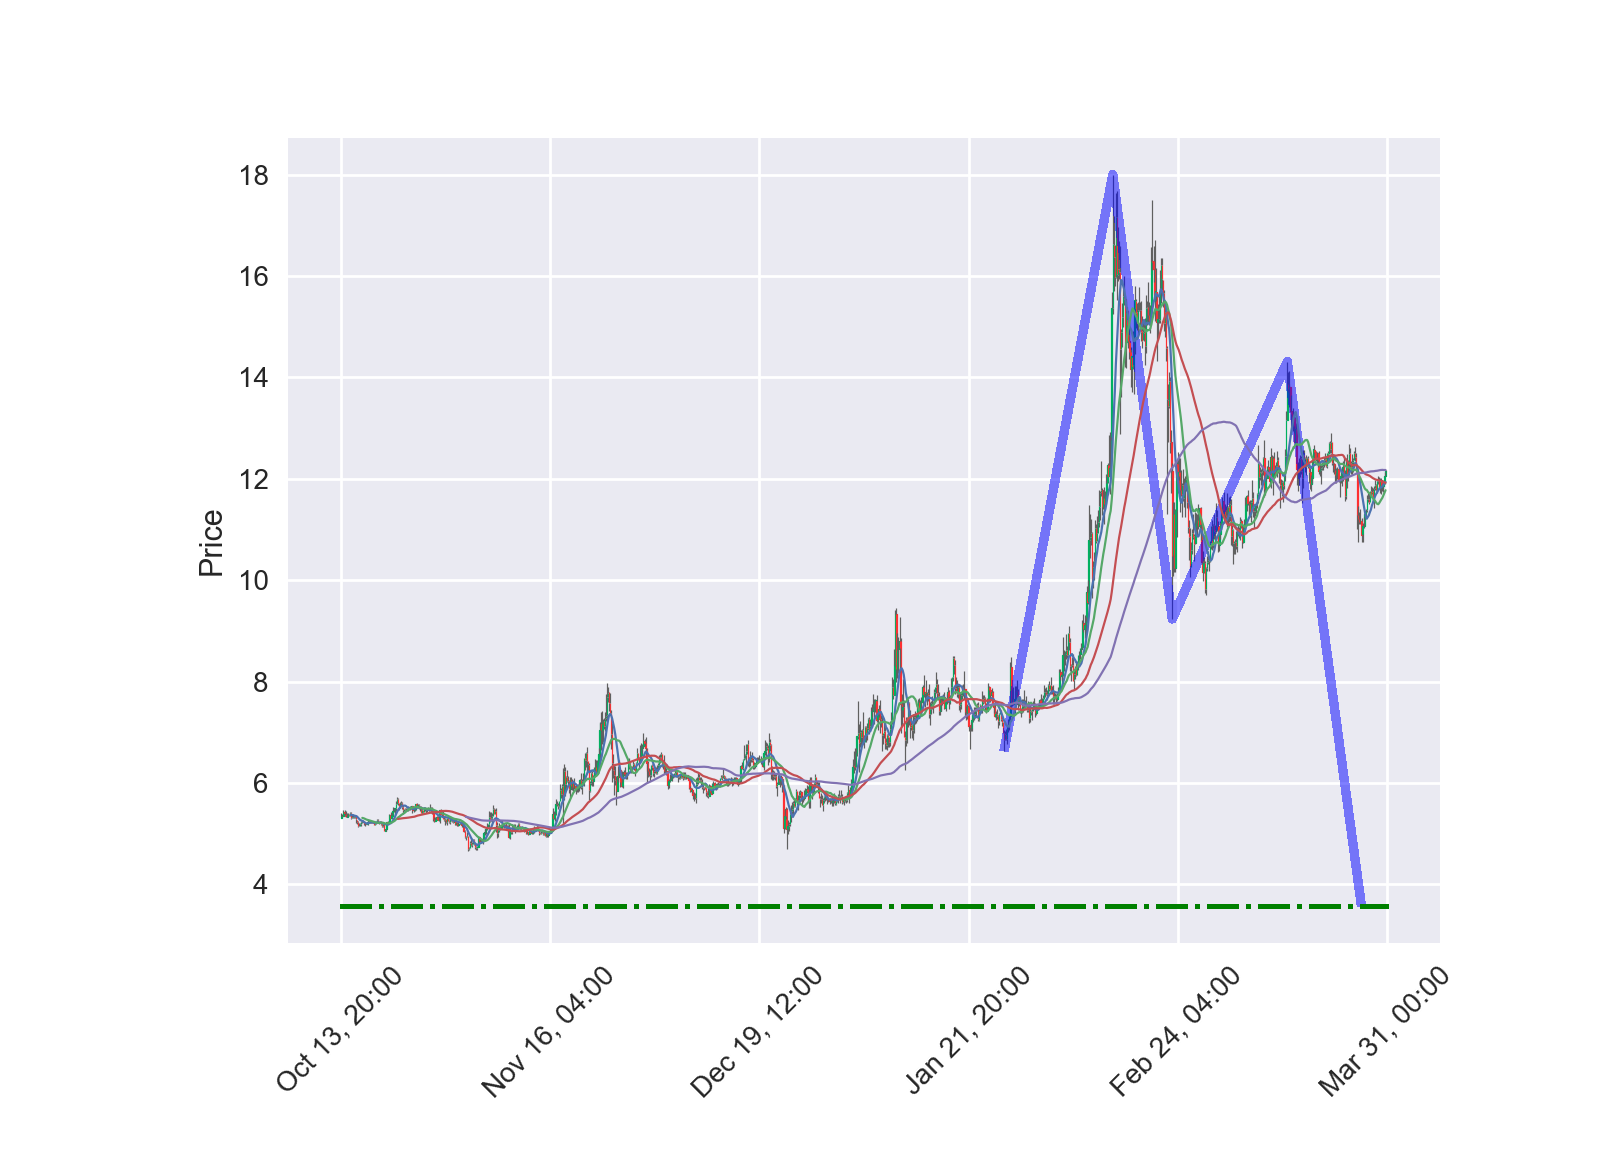

<IPython.core.display.Javascript object>


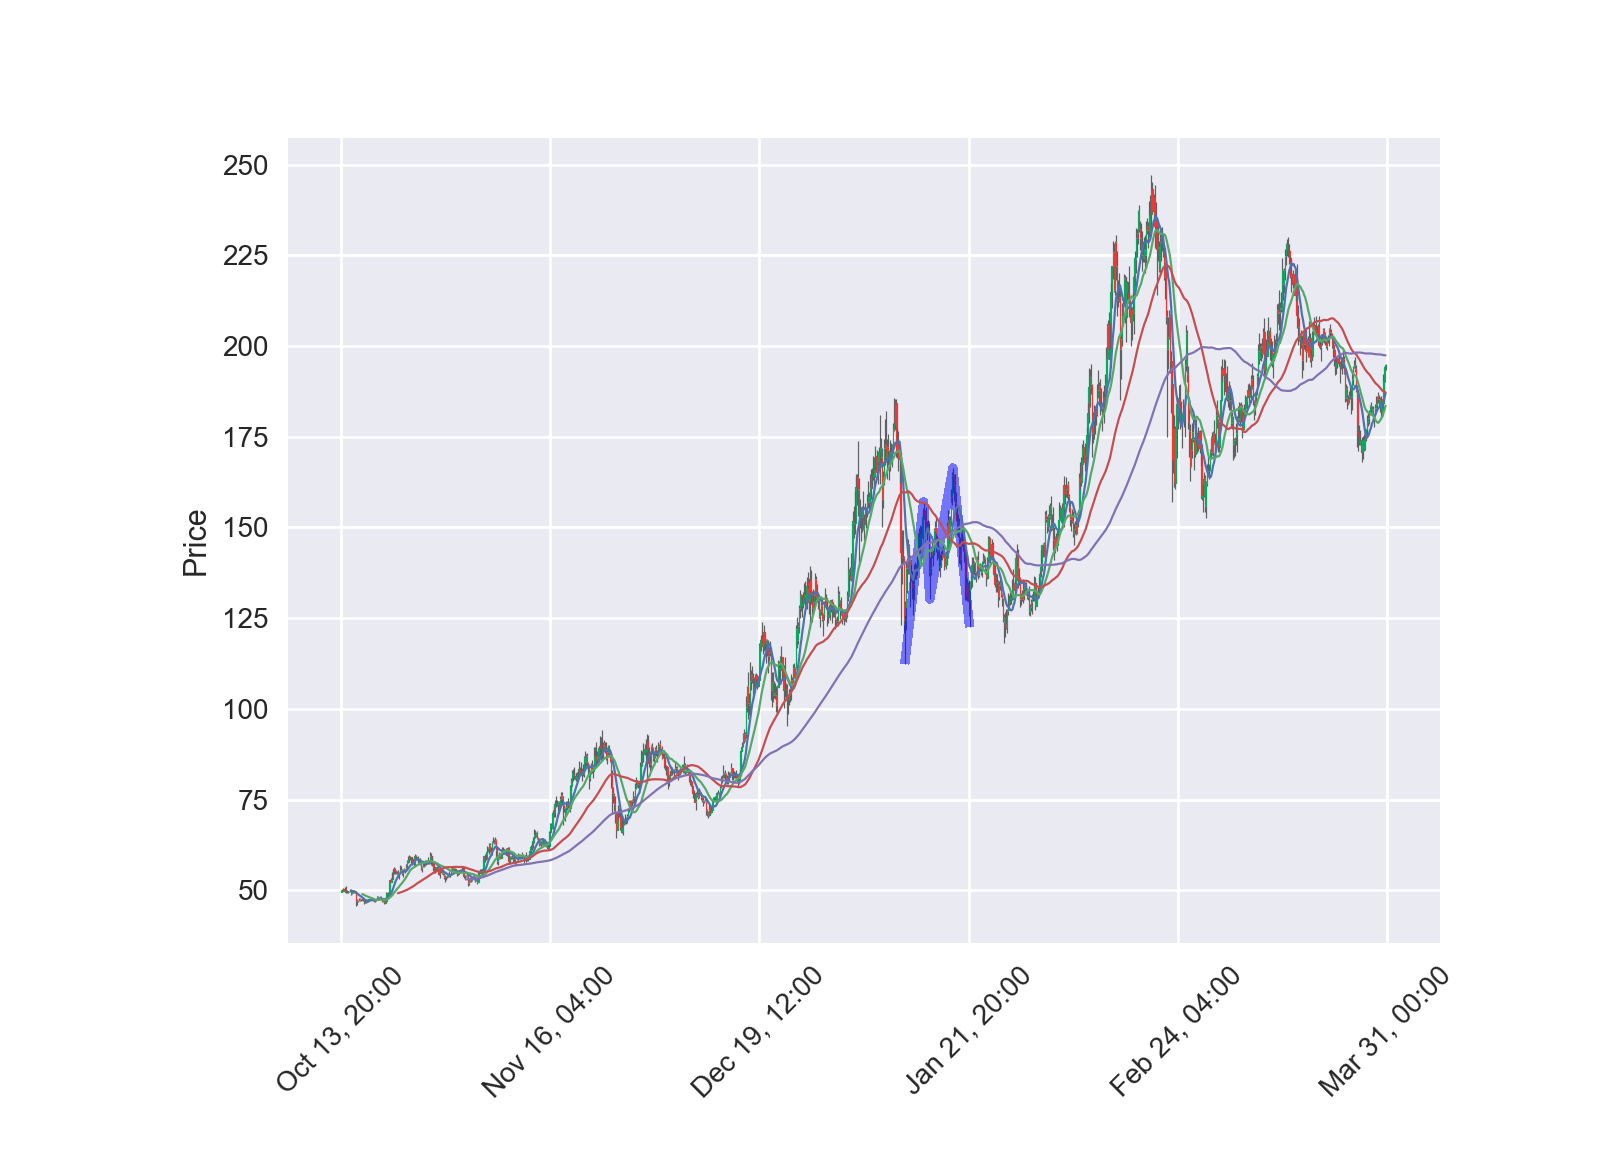

In [30]:
s = ['BTC/USDT', 'ETH/USDT', 'BCH/USDT', 'ETC/USDT', 'ADA/USDT','XMR/USDT', 'DOT/USDT', 'EOS/USDT', 'LTC/USDT']
#s = ['BTC/USDT', 'ETH/USDT', 'DOT/USDT','BCH/USDT']

#search(bn, s, periods=['30m', '1h', '4h', '1d'], predict=True)
#search(hb, s, periods=['15m', '30m', '1h', '4h'], predict=True, only_last=True, alert=False, plot=True)
#search(hb, s, periods=['5m'], predict=True, only_last=True, alert=True)
search(hb, s, periods=['1h', '4h'], predict=True, only_last=False, alert=False, plot=True)


### 主流币/BTC

In [ ]:
#s = ['ETH/BTC', 'BCH/BTC', 'EOS/BTC', 'ETC/BTC', 'ADA/BTC', 'DOT/BTC', 'LTC/BTC']
s = ['ETH/BTC']

search(hb, s)

### 主流平台币

In [ ]:
#from harmo import search
search(hb, ['HT/USDT'])
search(ok, ['OKB/USDT'])
search(bn, ['BNB/USDT'])

### DEFI

In [ ]:
s = ['UNI/USDT', 'XMR/USDT', 'ATOM/USDT', 'COMP/USDT', 'SOL/USDT', 'ALGO/USDT', 'FIL/USDT', 'XLM/USDT', 'AAVE/USDT']
search(hb, s, periods=['15m','30m', '1h', '4h'], predict=True, only_last=True,plot=True)
#search(hb, s, periods=['5m'], predict=True, only_last=True)

### 杂项

In [ ]:
search(hb, ['BTC/USDT', 'ETH/USDT', 'LTC/USDT'], periods=['5m', '15m', '30m', '1h', '4h'],predict=True) 

In [ ]:
search(hb, ['ETH/USDT','ATOM/USDT', 'UNI/USDT','ADA/USDT', 'ETC/USDT'], periods=['5m', '15m', '30m', '1h', '4h'], plot=True, only_last=True) 

In [ ]:
search(hb, ['FIL/USDT', ], periods=['5m', '15m', '30m', '1h', '4h'], plot=True, predict=True) 

### LOOP

In [ ]:

s = ['BTC/USDT', 'ETH/USDT', 'BCH/USDT', 'ETC/USDT', 'ADA/USDT','XRP/USDT', 'DOT/USDT', 'EOS/USDT', 'LTC/USDT']
s = ['UNI/USDT', 'XMR/USDT', 'ATOM/USDT', 'COMP/USDT', 'SOL/USDT', 'ALGO/USDT', 'FIL/USDT', 'XLM/USDT', 'AAVE/USDT', *s]

In [ ]:
search(hb, ['ETC/USDT', ], periods=['5m', '15m', '30m', '1h', '4h'], plot=True, predict=True, only_last=True) 

In [ ]:
periods = ['5m','15m','30m','1h','4h']
with Pool(8) as p:
    r = p.map(partial(search, hb, ['XMR/USDT'], predict=True, only_last=True, alert=False, plot=False), [[pi] for pi in periods])

In [ ]:
with Pool(8) as p:
    r = p.map_async(partial(search, bn, periods=['5m','15m','30m','1h','4h'], predict=True, only_last=True, alert=False, plot=False), [[si] for si in s])
    r.get(timeout=240)